# SIRD

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import deepxde as dde

from deepxde.backend import tf
from scipy.integrate import solve_ivp

sns.set_theme(style="darkgrid")

Using backend: tensorflow.compat.v1

2023-03-05 23:35:20.892067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 23:35:20.963556: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-05 23:35:21.295482: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alonsolml/mambaforge/envs/pinn/

Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-03-05 23:35:21.681472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-05 23:35:21.695083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-05 23:35:21.695130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


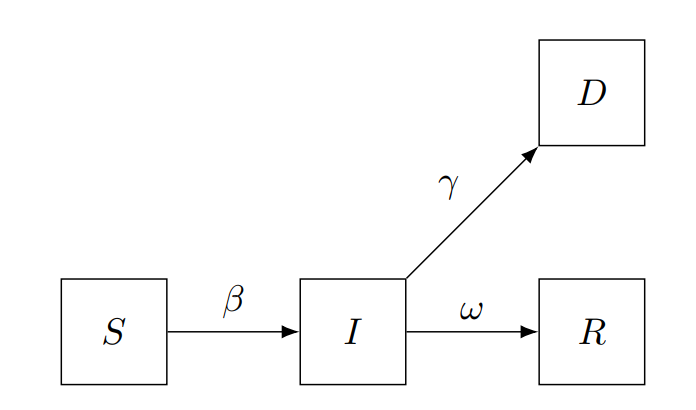

$$
\begin{aligned}
\frac{dS}{dt} &= - \frac{\beta S}{N} I  \\
\frac{dI}{dt} &= \frac{\beta S}{N} I - \omega I - \gamma I\\
\frac{dR}{dt} &= \omega I \\
\frac{dD}{dt} &= \gamma I
\end{aligned}
$$

| Variable   | Description |
| ----------- | ----------- |
| $S(t)$ | Number of __susceptible__ individuals|
| $I(t)$ | Number of __symptomatically infected__ individuals|
| $R(t)$ | Number of __removed__ individuals|
| $D(t)$ | Number of __deceased__ individuals|

| Parameter   | Description |
| ----------- | ----------- |
| $\beta$ | Transmission rate |
| $\omega$ | Recovery rate |
| $\gamma$ | Mortality rate |


## Synthetic data

In [2]:
N = 1e7
S_0 = N - 1
I_0 = 1
R_0 = 0
D_0 = 0
y0 = [S_0, I_0, R_0, D_0]  # Initial conditions vector

beta = 0.5
omega = 1 / 14
gamma = 0.1 / 14

parameters_real = {
    "beta": beta,
    "omega": omega,
    "gamma": gamma,
}

In [3]:
def generate_data(
    t_array,
    y0,
):

    def func(t, y):
        S, I, R, D = y
        dS_dt = - beta * S / N * I
        dI_dt = beta * S / N * I - omega * I - gamma * I 
        dR_dt = omega * I
        dD_dt = gamma * I

        return np.array([dS_dt, dI_dt, dR_dt, dD_dt])

    t_span = (t_array[0], t_array[-1])
    sol = solve_ivp(func, t_span, y0, t_eval=t_array)
    return sol.y.T

In [4]:
n_days = 120  # 3 months
t_train = np.arange(0, n_days, 1)[:, np.newaxis]
y_train = generate_data(np.ravel(t_train), y0)
y_train

array([[9.99999900e+06, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99999838e+06, 1.52414270e+00, 8.88377604e-02, 8.88377604e-03],
       [9.99999743e+06, 2.32307533e+00, 2.24250103e-01, 2.24250103e-02],
       [9.99999599e+06, 3.54036192e+00, 4.30569945e-01, 4.30569945e-02],
       [9.99999378e+06, 5.39618366e+00, 7.45116193e-01, 7.45116193e-02],
       [9.99999043e+06, 8.22597659e+00, 1.22474258e+00, 1.22474258e-01],
       [9.99998532e+06, 1.25313324e+01, 1.95446494e+00, 1.95446494e-01],
       [9.99997752e+06, 1.91039354e+01, 3.06846789e+00, 3.06846789e-01],
       [9.99996563e+06, 2.91254874e+01, 4.76704206e+00, 4.76704206e-01],
       [9.99994756e+06, 4.43602144e+01, 7.34921232e+00, 7.34921232e-01],
       [9.99991996e+06, 6.76159364e+01, 1.12908905e+01, 1.12908905e+00],
       [9.99987786e+06, 1.03106332e+02, 1.73062868e+01, 1.73062868e+00],
       [9.99981383e+06, 1.57075701e+02, 2.64538092e+01, 2.64538092e+00],
       [9.99971629e+06, 2.39284377e+02, 4.03878580e

/tmp/ipykernel_1477/2781507673.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


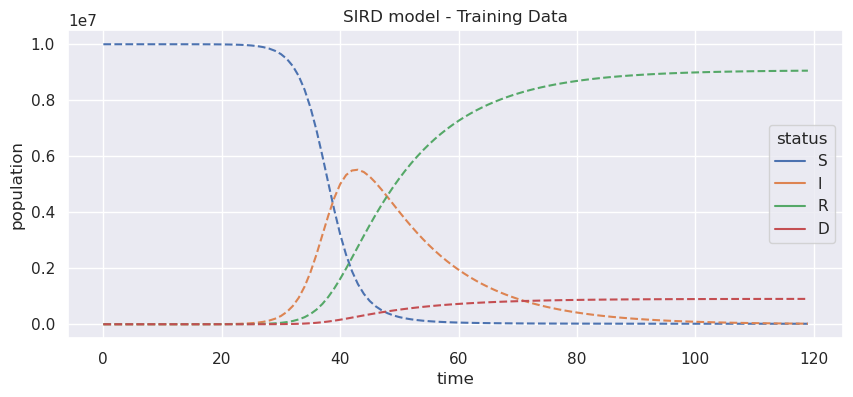

In [5]:
model_name = "SIRD"
populations_names = list(model_name)
data_real = (
        pd.DataFrame(y_train, columns=populations_names, index=t_train.ravel())
        .rename_axis("time")
        .reset_index()
        .melt(id_vars="time", var_name="status", value_name="population")
)

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(
    data=data_real,
    x="time",
    y="population",
    hue="status",
    legend=True,
    linestyle="dashed",
    ax=ax
)

ax.set_title(f"{model_name} model - Training Data")
fig.show()

## DINN

### Varibles

In [6]:
_beta = dde.Variable(0.0)
_omega = dde.Variable(0.0)
_gamma = dde.Variable(0.0)

### ODE Loss

$$
\begin{aligned}
\mathcal{L}_{\mathcal{F}_S} &= \frac{dS}{dt} - \left( - \frac{\beta S}{N} I \right) \\
\mathcal{L}_{\mathcal{F}_I} &= \frac{dI}{dt} - \left( \frac{\beta S}{N} I - \omega I - \gamma I \right) \\
\mathcal{L}_{\mathcal{F}_R} &= \frac{dR}{dt} - \omega I\\
\mathcal{L}_{\mathcal{F}_D} &= \frac{dD}{dt} - \gamma I
\end{aligned}
$$

In [7]:
def ode(t, y):

    S = y[:, 0:1]
    I = y[:, 1:2]
    R = y[:, 2:3]
    D = y[:, 3:4]

    dS_dt = dde.grad.jacobian(y, t, i=0)
    dI_dt = dde.grad.jacobian(y, t, i=1)
    dR_dt = dde.grad.jacobian(y, t, i=2)
    dD_dt = dde.grad.jacobian(y, t, i=3)

    return [
        dS_dt - ( - _beta * S / N * I ),
        dI_dt - ( _beta * S / N * I - _omega * I - _gamma * I  ),
        dR_dt - ( _omega * I ),
        dD_dt - ( _gamma * I )
    ]

### Initial Conditions

In [8]:
# Geometry
geom = dde.geometry.TimeDomain(t_train[0, 0], t_train[-1, 0])

# Boundaries
def boundary(_, on_initial):
    return on_initial

# Initial conditions
S_0, I_0, R_0, D_0 = y_train[0, :]
ic_S = dde.icbc.IC(geom, lambda x: S_0, boundary, component=0)
ic_I = dde.icbc.IC(geom, lambda x: I_0, boundary, component=1)
ic_R = dde.icbc.IC(geom, lambda x: R_0, boundary, component=2)
ic_D = dde.icbc.IC(geom, lambda x: D_0, boundary, component=3)

### Observed Data

In [9]:
observed_S = dde.icbc.PointSetBC(t_train, y_train[:, 0:1], component=0)
observed_I = dde.icbc.PointSetBC(t_train, y_train[:, 1:2], component=1)
observed_R = dde.icbc.PointSetBC(t_train, y_train[:, 2:3], component=2)
observed_D = dde.icbc.PointSetBC(t_train, y_train[:, 3:4], component=3)

### Data Model

In [10]:
data = dde.data.PDE(
    geom,
    ode,
    [
        ic_S,
        ic_I,
        ic_R,
        ic_D,
        observed_S,
        observed_I,
        observed_R,
        observed_D,
    ],
    num_domain=256,
    num_boundary=2,
    anchors=t_train,
)

### Neural Network

In [11]:
neurons = 64
layers = 3
activation = "relu"
net = dde.nn.FNN([1] + [neurons] * layers + [4], activation, "Glorot uniform")

### Training

In [12]:
variable_filename = "sird_variables.dat"
variable = dde.callbacks.VariableValue(
    [_beta, _omega, _gamma],
    period=100,
    filename=variable_filename
)

Compiling model...
Building feed-forward neural network...
'build' took 0.022485 s



/home/alonsolml/mambaforge/envs/pinn/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-03-05 23:35:22.550672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 23:35:22.551622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-05 23:35:22.551688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file t

'compile' took 0.633484 s

Initializing variables...
Training model...



2023-03-05 23:35:23.167275: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-05 23:35:23.196844: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa36c009410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-05 23:35:23.196863: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-05 23:35:23.221692: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-05 23:35:23.249886: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-03-05 23:35:23.281297: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [2.75e-05, 6.45e-04, 4.05e-02, 1.04e-02, 1.00e+14, 1.00e+00, 0.00e+00, 0.00e+00, 3.01e+13, 3.64e+12, 4.21e+13, 4.21e+11]    [2.75e-05, 6.45e-04, 4.05e-02, 1.04e-02, 1.00e+14, 1.00e+00, 0.00e+00, 0.00e+00, 3.01e+13, 3.64e+12, 4.21e+13, 4.21e+11]    []  


2023-03-05 23:35:23.773787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5000      [7.48e+08, 2.20e+08, 3.27e+08, 1.78e+08, 8.89e+12, 1.96e+11, 1.07e+13, 3.38e+10, 1.22e+13, 3.17e+12, 2.95e+13, 3.35e+11]    [7.48e+08, 2.20e+08, 3.27e+08, 1.78e+08, 8.89e+12, 1.96e+11, 1.07e+13, 3.38e+10, 1.22e+13, 3.17e+12, 2.95e+13, 3.35e+11]    []  
10000     [1.62e+09, 1.62e+09, 2.20e+09, 1.70e+07, 4.86e+08, 2.56e+09, 5.07e+09, 6.29e+07, 6.07e+11, 8.19e+11, 1.00e+12, 6.07e+09]    [1.62e+09, 1.62e+09, 2.20e+09, 1.70e+07, 4.86e+08, 2.56e+09, 5.07e+09, 6.29e+07, 6.07e+11, 8.19e+11, 1.00e+12, 6.07e+09]    []  
15000     [1.29e+09, 1.24e+09, 1.93e+09, 2.21e+07, 5.79e+07, 6.81e+06, 5.61e+07, 3.69e+05, 1.50e+10, 1.83e+10, 5.82e+10, 1.72e+08]    [1.29e+09, 1.24e+09, 1.93e+09, 2.21e+07, 5.79e+07, 6.81e+06, 5.61e+07, 3.69e+05, 1.50e+10, 1.83e+10, 5.82e+10, 1.72e+08]    []  
20000     [2.13e+08, 3.14e+08, 1.21e+08, 2.83e+06, 7.11e+05, 7.91e+05, 6.32e+04, 2.75e+06, 8.69e+07, 5.27e+08, 4.30e+08, 2.71e+07]    [2.13e+08, 3.14e+08, 1.21e+08, 2.83e+06, 7.11e+05, 7.91e+05, 6.32e+04, 2.75e+

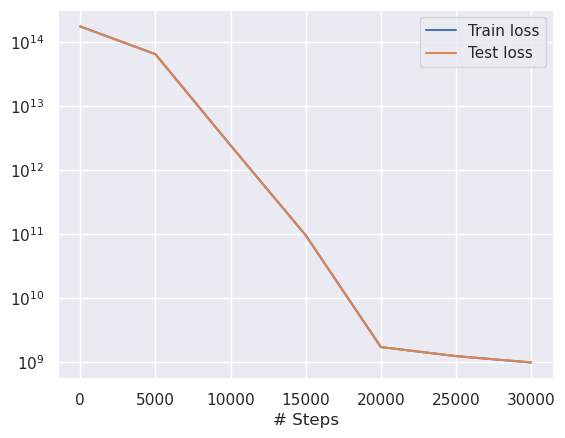

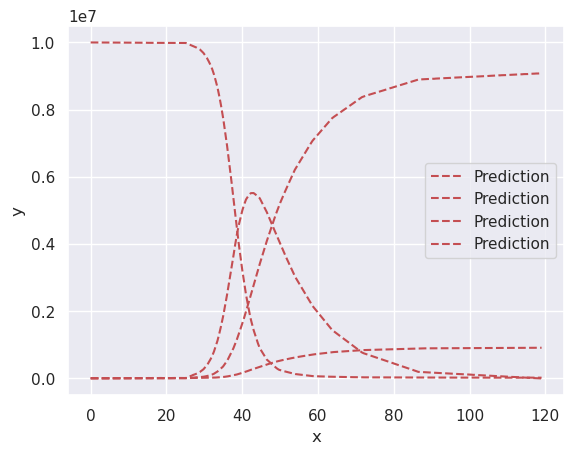

In [13]:
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=1e-3,
    external_trainable_variables=[_beta, _omega, _gamma]
)
losshistory, train_state = model.train(
    iterations=30000,
    display_every=5000,
    callbacks=[variable]
)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

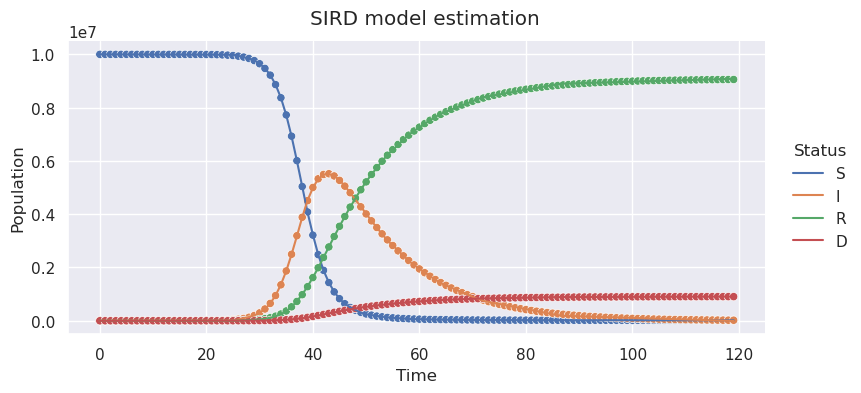

In [14]:
t_pred =  np.arange(0, n_days, 1)[:, np.newaxis]
y_pred = model.predict(t_pred)
data_pred = (
    pd.DataFrame(y_pred, columns=populations_names, index=t_pred.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)

g = sns.relplot(
    data=data_pred,
    x="time",
    y="population",
    hue="status",
    kind="line",
    aspect=2,
    height=4
)

sns.scatterplot(
    data=data_real,
    x="time",
    y="population",
    hue="status",
    ax=g.ax,
    legend=False
)

(
    g.set_axis_labels("Time", "Population")
    .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"SIRD model estimation")

plt.savefig("sird_prediction.png", dpi=300)
plt.show()

In [15]:
lines = open(variable_filename, "r").readlines()
raw_parameters_pred_history = np.array(
    [
         np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]

parameters_pred_history = {   
    name: raw_parameters_pred_history[:, i]
    for i, (name, nominal) in enumerate(parameters_real.items())
}

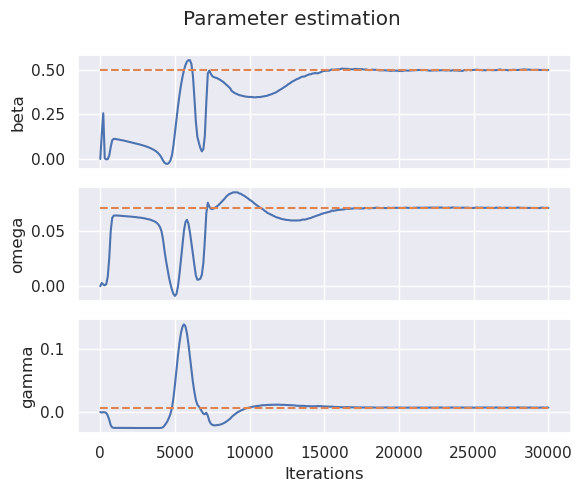

In [16]:
n_callbacis, n_variables = raw_parameters_pred_history.shape
fig, axes = plt.subplots(nrows=n_variables, sharex=True, figsize=(6, 5), layout="constrained")
for ax, (parameter, parameter_value) in zip(axes, parameters_real.items()):
    ax.plot(iterations, parameters_pred_history[parameter] , "-")
    ax.plot(iterations, np.ones_like(iterations) * parameter_value, "--")
    ax.set_ylabel(parameter)
ax.set_xlabel("Iterations")
fig.suptitle("Parameter estimation")
fig.tight_layout()
fig.savefig("sird_parameter_estimation.png", dpi=300)


In [17]:
parameters_pred = {
    name: var for name, var in zip(parameters_real.keys(), variable.value)
}
error_df = (
    pd.DataFrame(
        {
            "Real": parameters_real,
            "Predicted": parameters_pred
        }
    )
    .assign(
        **{"Relative Error": lambda x: (x["Real"] - x["Predicted"]).abs() / x["Real"]}
    )
)
error_df

,Real,Predicted,Relative Error
beta,0.500000,0.499509,0.000982
omega,0.071429,0.071093,0.004704
gamma,0.007143,0.007077,0.009180


In [20]:
print(
    error_df.style
    .format(
        {
            "Real": "{:.4f}",
            "Predicted": "{:.4f}",
            "Relative Error": "{:.4f}",
        }
    ).to_latex(
        label="tab:sird_errors",
        caption="Parameter predictions and relative errors for SIRD model.",   
    )
)

\begin{table}
\caption{Parameter predictions and relative errors.}
\label{tab:sird_errors}
\begin{tabular}{lrrr}
 & Real & Predicted & Relative Error \\
beta & 0.5000 & 0.4995 & 0.0010 \\
omega & 0.0714 & 0.0711 & 0.0047 \\
gamma & 0.0071 & 0.0071 & 0.0092 \\
\end{tabular}
\end{table}

